# GAIT ANALYSIS IN PARKINSON'S DISEASE

In this work , we used signals of free gait acquired during 2 minutes approx. in six patients with Parkinson's Disease (PD) and six elderly healthy controls (HC). The age range was balanced. Signals were collected from two devices in both feet: an accelerometer and a gyroscope with 100 Hz sampling frequency. 

The goal of this project is to between classify healthy and pathological subjects from his/her gait pattern.

### Importing the required libraries

We imported different libraries from Tensorflow, scikit-learn, and scipy. The latter aiming to read the data in Matlab format

In [106]:
# To load .mat files
from tensorflow.keras.utils import to_categorical
from scipy.io import loadmat

# To make graphics and metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from scipy import interp
from itertools import cycle
import itertools

# lstm model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, CuDNNLSTM, CuDNNGRU
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K

### Loading the data and visualizing it

We defined a function to load the .mat format data

In [2]:
!wget https://www.dropbox.com/s/hx2old2bh8oawj5/gaitData.zip
!unzip gaitData.zip

--2019-06-01 19:02:31--  https://www.dropbox.com/s/hx2old2bh8oawj5/gaitData.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/hx2old2bh8oawj5/gaitData.zip [following]
--2019-06-01 19:02:32--  https://www.dropbox.com/s/raw/hx2old2bh8oawj5/gaitData.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4bc2f89b9b921ae956514d98c7.dl.dropboxusercontent.com/cd/0/inline/AiAz7LBepkSfOsnPQqDHI9R7gvis5gk7epR5QrRjbWhbvS5W9tt6JQKwy1rqSupLMdcGUzpkjbYiV1PFSq2Q6xq7ZPzl6xoJeNrU6teThc0wiA/file# [following]
--2019-06-01 19:02:33--  https://uc4bc2f89b9b921ae956514d98c7.dl.dropboxusercontent.com/cd/0/inline/AiAz7LBepkSfOsnPQqDHI9R7gvis5gk7epR5QrRjbWhbvS5W9tt6JQKwy1rqSupLMdcGUzpkjbYiV1PFSq2Q6xq7ZPzl6xoJeNrU6teThc0wiA/file
Resolving uc4bc2f

In [55]:
def loadData(filepath, filename, foot = 'left'):  
    rawData = loadmat(filepath + filename)
    if foot == 'left':
        data = rawData['datas'][0][0]
    elif foot == 'right':
        data = rawData['datas'][1][0]
    else:
        #print('both feet')
        data = np.concatenate((rawData['datas'][0][0], rawData['datas'][1][0]), axis = 0)   
    return np.transpose(data)

Next, we show an example of signals acquired from the right foot of a healthy control, during the first 20 seconds:

(12591, 6)


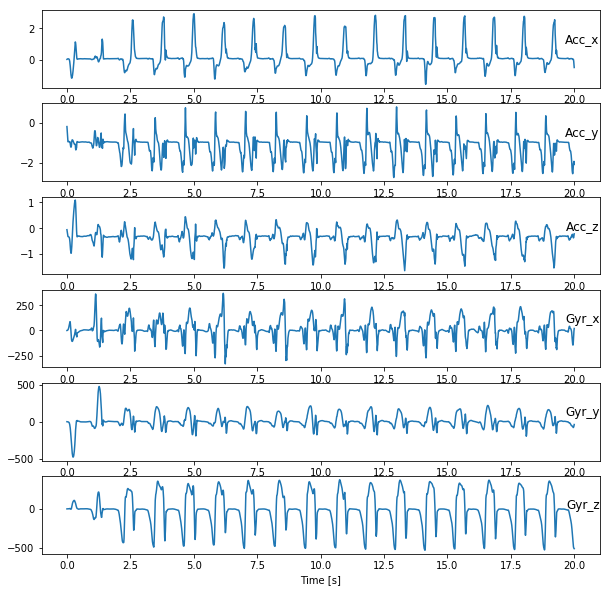

In [107]:
from matplotlib import pyplot
# load dataset

sources = ['Acc_x', 'Acc_y', 'Acc_z', 'Gyr_x', 'Gyr_y', 'Gyr_z']
HC = loadData('./gaitData/EHC/', '002.mat', foot = 'right')

Fs = 100
t = np.linspace(0, 20, 20*Fs)

print(HC.shape)

i = 1
# plot each column
pyplot.figure(figsize=(10,10))
for source in range(len(sources)):
    pyplot.subplot(len(sources), 1, i)
    pyplot.plot(t,HC[:20*Fs, source])
    pyplot.xlabel('Time [s]')
    pyplot.title(sources[source], y=0.5, loc='right')
    i += 1
pyplot.show()

And now, we show an example of signals acquired from the right foot of a PD patient, during the first 20 seconds too:

(9784, 6)


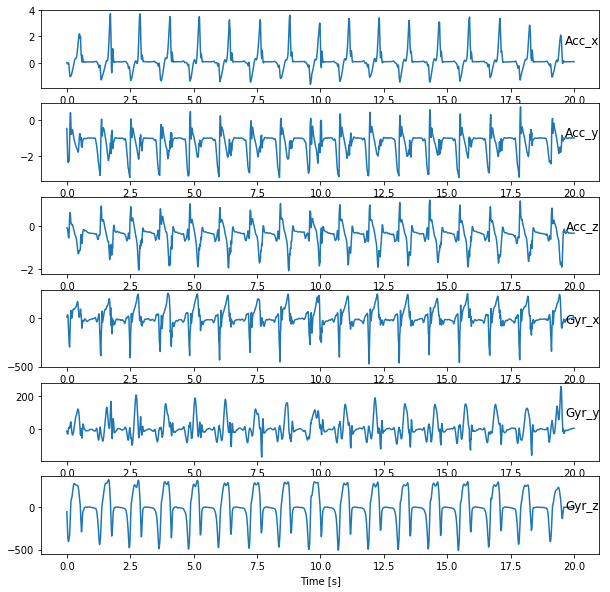

In [108]:
PD = loadData('./gaitData/PD/', '001.mat', foot = 'right')

print(PD.shape)

i = 1
# plot each column
pyplot.figure(figsize=(10,10))
for source in range(len(sources)):
    pyplot.subplot(len(sources), 1, i)
    pyplot.plot(t,PD[:20*Fs, source])
    pyplot.xlabel('Time [s]')
    pyplot.title(sources[source], y=0.5, loc='right')
    i += 1
pyplot.show()

### Creating the dataset

We built another function that segments the data in the format required to evaluate the different recurrent neural networks' architectures, that is [samples, data to build the model, features]. In this case, we used 128 data to train the model, with overlapping = 50%. We concatenated data of the both groups. We labeled the signals as 0 for healthy controls and 1 for patients with PD.

In [109]:
def create_dataset(dataset, look_back=1, time_ahead = 1, overlap = 1, label = 0):
    dataX, dataY = [], []
    tem = look_back + time_ahead - overlap
    for i in range(int((len(dataset) - tem)/overlap)):
        startx = i*overlap
        endx = startx + look_back  
        a = dataset[startx:endx]
        dataX.append(a)
        dataY.append(label)
    return np.array(dataX), np.array(dataY)

In [110]:
groups = ['./gaitData/EHC/', './gaitData/PD/']
fileNames = ['001', '002', '003', '004', '005', '006']

for group in groups:
    
    target = 1 if group == './gaitData/PD/' else 0
    
    for subject in fileNames:
        tempX, tempY = create_dataset(loadData(group, subject + '.mat', foot = 'both'),
                                      look_back=128, overlap = 64, label = target)        

        if group == './gaitData/EHC/' and subject ==  '001':
            X, Y = tempX, tempY
        else:             
            X, Y = np.concatenate((X, tempX), axis = 0), np.concatenate((Y, tempY), axis = 0)

print (X.shape, Y.shape)

(2378, 128, 12) (2378,)


We applied the one-hot encoding. Next, we show the final dimensions of the target:

In [111]:
# One-hot encoding 
Y = to_categorical(Y)

print(X.shape)
print(Y.shape)

(2378, 128, 12)
(2378, 2)


## Trying with different architectures

We tested 4 architectures. First, we applied 3 different architectures of recurrent neural networks: LSTM, simple RNN, and GRU. We applied these structures with an additional dense layer with 100 units. Finally, we applied a stacked LSTM, in order to increase the accuracy.

In [112]:
def evaluate_model_RNN(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 1, 15, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    K.clear_session()
    
    model = Sequential()
    model.add(SimpleRNN(100, input_shape=(n_timesteps, n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    history=model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose = verbose, validation_split=0.2)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose = verbose)
    return accuracy, model, history

In [113]:
def evaluate_model_LSTM(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 1, 15, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    K.clear_session()
    
    model = Sequential()
    #model.add(CuDNNLSTM(100, input_shape=(n_timesteps, n_features)))
    model.add(LSTM(100, input_shape=(n_timesteps, n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    history= model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose = verbose, validation_split=0.2)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose = verbose)
    return accuracy, model, history

In [114]:
# fit and evaluate a model
def evaluate_model_GRU(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 1, 15, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    K.clear_session()
    model = Sequential()
    #model.add(CuDNNGRU(100, input_shape=(n_timesteps, n_features)))
    model.add(GRU(100, input_shape=(n_timesteps, n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    history=model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose = verbose, validation_split=0.2)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose = verbose)
    return accuracy, model, history

In [115]:
def stacked_LSTM(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 1, 15, 64
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    K.clear_session()
    model = Sequential()
    #model.add(CuDNNLSTM(16, return_sequences=True, input_shape=(n_timesteps, n_features)))
    #model.add(CuDNNLSTM(32, return_sequences=True))
    #model.add(CuDNNLSTM(16))
    model.add(LSTM(16, return_sequences=True, input_shape=(n_timesteps, n_features)))
    model.add(LSTM(32, return_sequences=True))
    model.add(LSTM(16))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    history=model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose = verbose, validation_split=0.2)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose = verbose)
    return accuracy, model, history

We defined a function to run the aforementioned models automatically.

In [116]:
# run an experiment
def run_experiment(X, y, repeats=1, architecture = 'lstm'):
    # load data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, shuffle = True)
    # repeat experiment
    scores = list()
    for r in range(repeats):
        
        if architecture == 'lstm':
            score, model, history= evaluate_model_LSTM(X_train, y_train, X_test, y_test)
        elif architecture == 'gru':
            score, model, history = evaluate_model_GRU(X_train, y_train, X_test, y_test)
        elif architecture == 'rnn':
            score, model, history = evaluate_model_RNN(X_train, y_train, X_test, y_test)
        else:
            score, model, history = stacked_LSTM(X_train, y_train, X_test, y_test)
            
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)  
    print(scores)
    plt.figure()
    plt.plot(scores)
    plt.title('Average accuracy in each repeat')
    plt.ylabel('Accuracy')
    plt.xlabel('Repeat')
    plt.grid('on');
    plt.show()
    return scores, model, history, X_test, y_test

Function to create the confusion matrix with which each of the models will be evaluated.

In [117]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Next, a function is created to calculate the different metrics with which each of the models will be evaluated: auc, roc, sensitivity, accuracy, recall, F1 score and Cohen kappa score. Each model is executed ten times to verify its variability in accuracy; however, the other metrics are only evaluated in the last model. We have performed the procedure in this way because in initial tests no large changes are noticed between repetitions and to decrease the computational load.

In [118]:
def metrics_def(model, history, X_test, y_test):
    from sklearn.metrics import roc_curve, auc
    # predict probabilities for test set
    yhat_probs = model.predict(X_test, verbose=0)
    # predict crisp classes for test set
    yhat_classes = model.predict_classes(X_test, verbose=0)
    
    # Compute ROC curve and ROC area for each class
    n_classes=2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], yhat_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), yhat_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # reduce to 1d array
    yhat_probs = yhat_probs[:, 0]
    y_test = y_test[:, 1]
    
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, yhat_classes)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(y_test, yhat_classes)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(y_test, yhat_classes)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, yhat_classes)
    print('F1 score: %f' % f1)

    # kappa
    kappa = cohen_kappa_score(y_test, yhat_classes)
    print('Cohens kappa: %f' % kappa)
    # ROC AUC
    auc = roc_auc_score(y_test, yhat_probs)
    print('ROC AUC: %f' % (1-auc))
    # confusion matrix
    matrix = confusion_matrix(y_test, yhat_classes)
    return history, fpr, tpr, n_classes, matrix, roc_auc

The next segment of code is used to perform the different performance graphs.

In [119]:
def metric_graphics(history, fpr, tpr, n_classes, matrix, roc_auc):
    %matplotlib inline
    from sklearn.metrics import roc_curve, auc
    # Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plot_confusion_matrix(cm= np.array(matrix), 
                      normalize    = False,
                      target_names = ['PD', 'HC'],
                      title        = "Confusion Matrix")
    
    plot_confusion_matrix(cm= np.array(matrix), 
                          normalize    = True,
                          target_names = ['PD', 'HC'],
                          title        = "Confusion Matrix Normalized")
      
    # summarize history for accuracy
    plt.figure(figsize=(20,7))
    ax1=plt.subplot(121)
    ax1.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid(True);
    #plt.show()
    # summarize history for loss
    ax2=plt.subplot(122)
    ax2.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid(True);
    plt.show()  
    
    # Plot ROC curves
    lw = 2
    plt.figure(figsize=(20,7))
    ax1=plt.subplot(121)
    ax1.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC characteristic PD patients')
    plt.legend(loc="lower right")
    
    ax2=plt.subplot(122)
    ax2.plot(fpr[1], tpr[1], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC characteristic example HC subjects')
    plt.legend(loc="lower right")
    plt.show()    
    
    # Plot all ROC curves
    plt.figure(figsize=(7,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

Note that we execute the training over the dataset with repetitions. Such repetitions are intended to reduce bias of the model. We applied the hold-out method to validate the models.

### 1. LSTM: both feet

Train on 1331 samples, validate on 333 samples
Epoch 1/15
1331/1331 [==============================] - 3s 3ms/sample - loss: 0.7077 - acc: 0.5620 - val_loss: 0.6158 - val_acc: 0.6216
Epoch 2/15
1331/1331 [==============================] - 0s 211us/sample - loss: 0.6388 - acc: 0.6386 - val_loss: 0.5749 - val_acc: 0.7477
Epoch 3/15
1331/1331 [==============================] - 0s 179us/sample - loss: 0.5789 - acc: 0.7032 - val_loss: 0.5431 - val_acc: 0.7838
Epoch 4/15
1331/1331 [==============================] - 0s 176us/sample - loss: 0.5481 - acc: 0.7303 - val_loss: 0.5144 - val_acc: 0.7508
Epoch 5/15
1331/1331 [==============================] - 0s 178us/sample - loss: 0.5080 - acc: 0.7551 - val_loss: 0.4823 - val_acc: 0.7958
Epoch 6/15
1331/1331 [==============================] - 0s 180us/sample - loss: 0.5060 - acc: 0.7431 - val_loss: 0.4570 - val_acc: 0.7718
Epoch 7/15
1331/1331 [==============================] - 0s 178us/sample - loss: 0.4511 - acc: 0.7986 - val_loss: 0.4277 - val_a

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


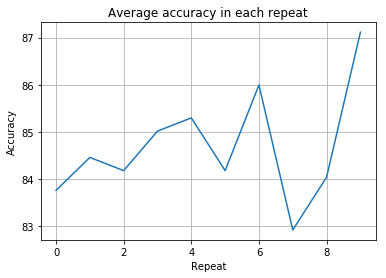

In [65]:
scores, model, history, X_test, y_test = run_experiment(X, Y, repeats=10, architecture = 'lstm')

In [66]:
print('The accuracy was %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
history, fpr, tpr, n_classes, matrix, roc_auc=metrics_def(model, history, X_test, y_test)

The accuracy was 84.692 +/- 1.145
Accuracy: 0.871148
Precision: 0.850163
Recall: 0.850163
F1 score: 0.850163
Cohens kappa: 0.737141
ROC AUC: 0.934077


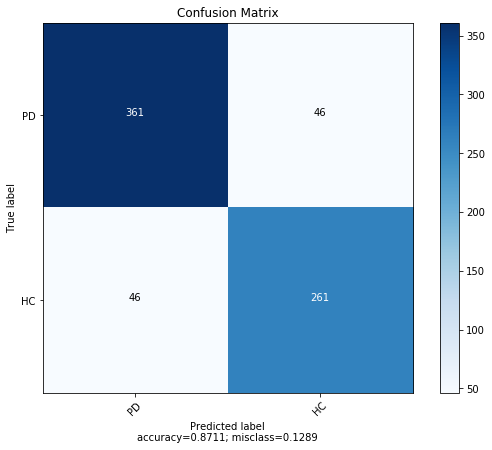

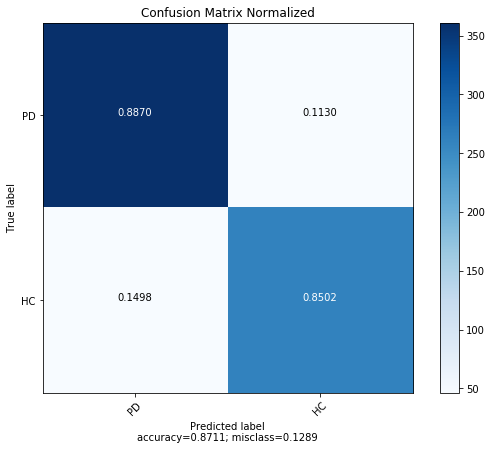

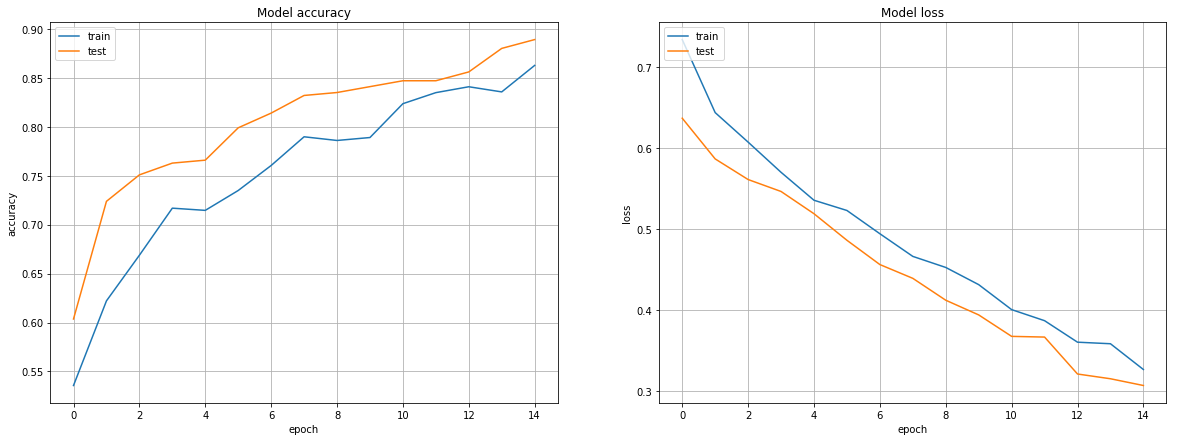

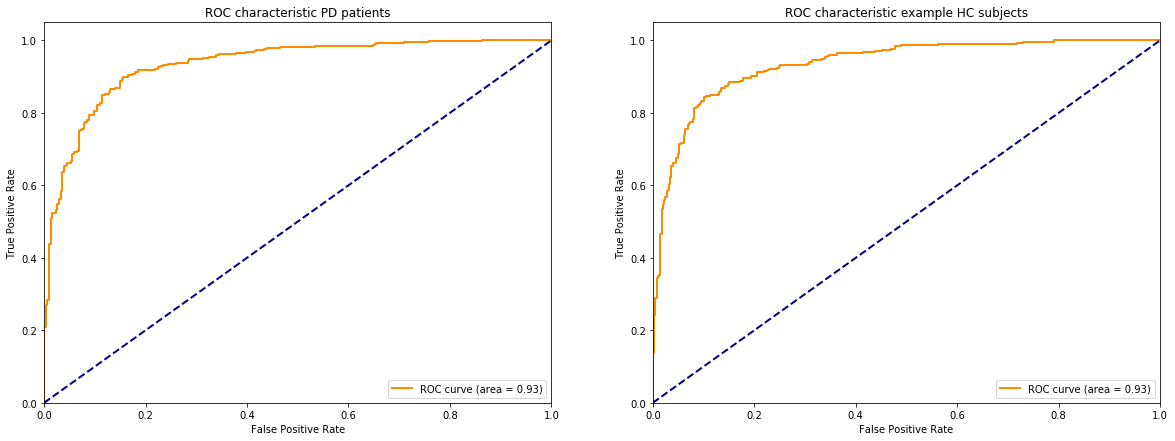

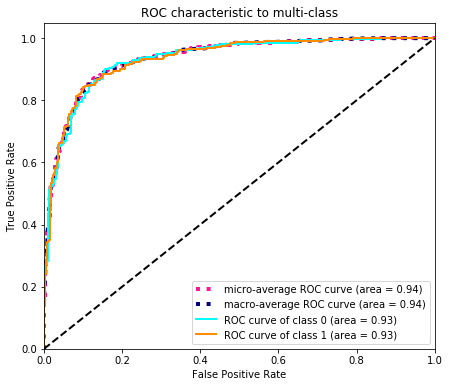

In [67]:
metric_graphics(history, fpr, tpr, n_classes, matrix, roc_auc)

### 2. RNN: both feet

Train on 1331 samples, validate on 333 samples
Epoch 1/15
1331/1331 [==============================] - 2s 1ms/sample - loss: 0.8457 - acc: 0.5267 - val_loss: 0.6838 - val_acc: 0.6126
Epoch 2/15
1331/1331 [==============================] - 1s 1ms/sample - loss: 0.7500 - acc: 0.5642 - val_loss: 0.6371 - val_acc: 0.6637
Epoch 3/15
1331/1331 [==============================] - 2s 1ms/sample - loss: 0.7175 - acc: 0.5778 - val_loss: 0.6209 - val_acc: 0.6547
Epoch 4/15
1331/1331 [==============================] - 2s 1ms/sample - loss: 0.7214 - acc: 0.5748 - val_loss: 0.6153 - val_acc: 0.6517
Epoch 5/15
1331/1331 [==============================] - 2s 1ms/sample - loss: 0.6862 - acc: 0.5920 - val_loss: 0.5973 - val_acc: 0.6967
Epoch 6/15
1331/1331 [==============================] - 2s 1ms/sample - loss: 0.6764 - acc: 0.5995 - val_loss: 0.6142 - val_acc: 0.6817
Epoch 7/15
1331/1331 [==============================] - 2s 1ms/sample - loss: 0.6597 - acc: 0.6206 - val_loss: 0.6057 - val_acc: 0.6547
E

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


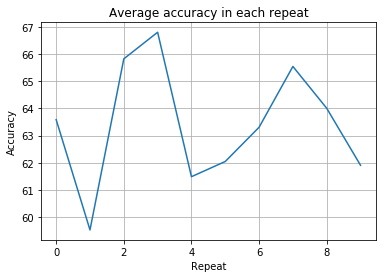

In [68]:
scores, model, history, X_test, y_test = run_experiment(X, Y, repeats=10, architecture = 'rnn')

In [69]:
print('The accuracy was %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
history, fpr, tpr, n_classes, matrix, roc_auc=metrics_def(model, history, X_test, y_test)

The accuracy was 63.403 +/- 2.128
Accuracy: 0.619048
Precision: 0.599034
Recall: 0.396166
F1 score: 0.476923
Cohens kappa: 0.196485
ROC AUC: 0.681826


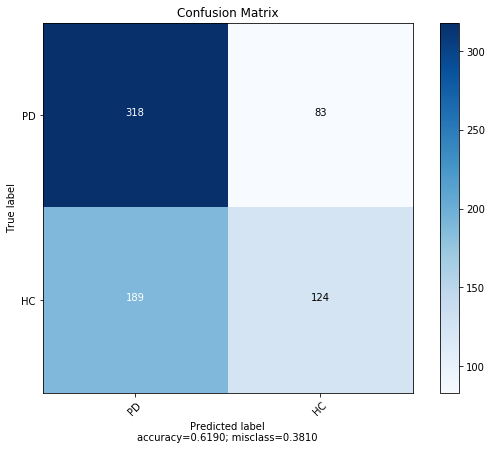

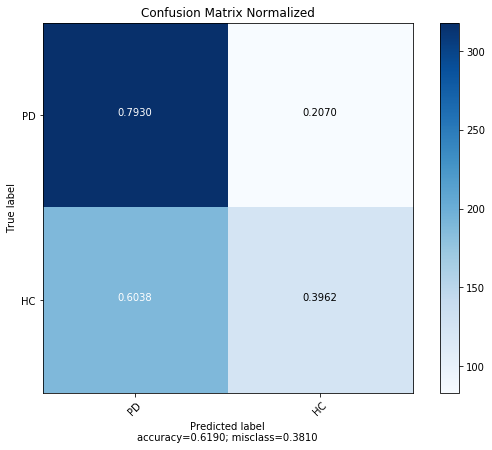

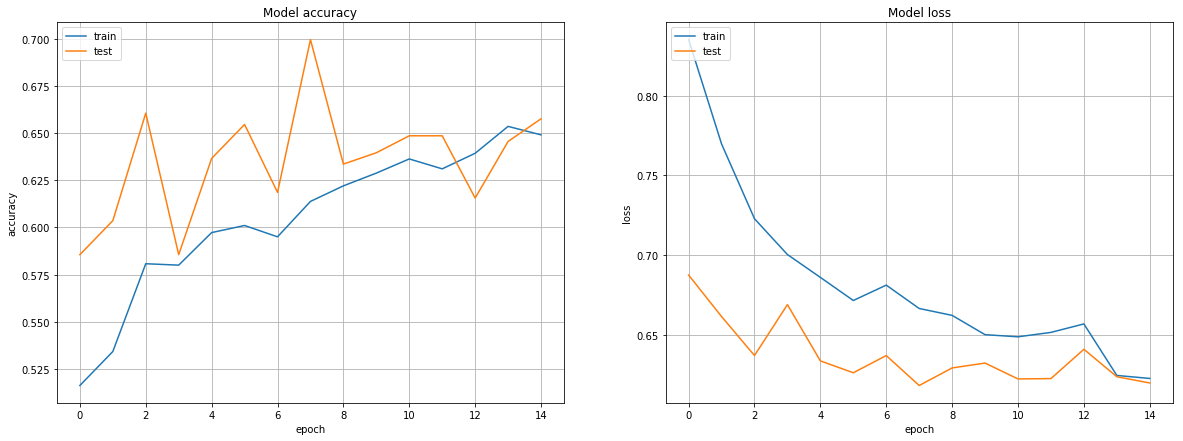

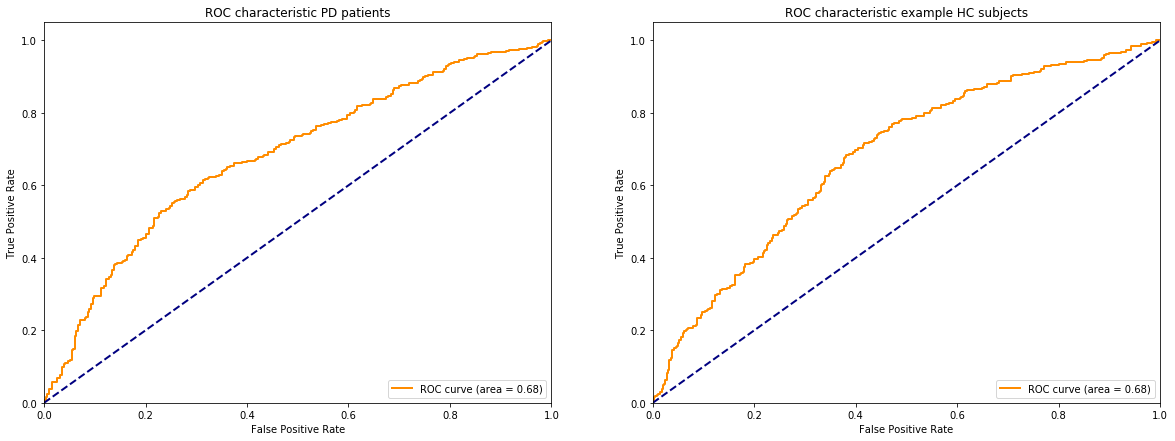

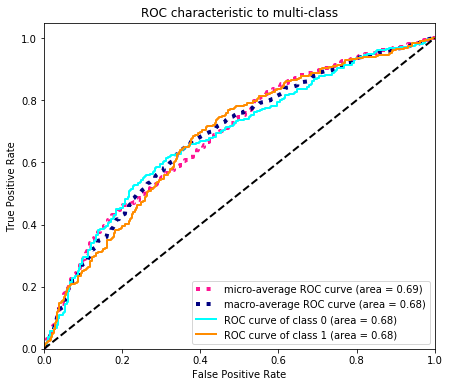

In [70]:
metric_graphics(history, fpr, tpr, n_classes, matrix, roc_auc)

### 3. GRU: both feet

Train on 1331 samples, validate on 333 samples
Epoch 1/15
1331/1331 [==============================] - 1s 502us/sample - loss: 0.8084 - acc: 0.5515 - val_loss: 0.6015 - val_acc: 0.6607
Epoch 2/15
1331/1331 [==============================] - 0s 204us/sample - loss: 0.6284 - acc: 0.6551 - val_loss: 0.5320 - val_acc: 0.7087
Epoch 3/15
1331/1331 [==============================] - 0s 172us/sample - loss: 0.5723 - acc: 0.6980 - val_loss: 0.4883 - val_acc: 0.7568
Epoch 4/15
1331/1331 [==============================] - 0s 171us/sample - loss: 0.5388 - acc: 0.7220 - val_loss: 0.4513 - val_acc: 0.7838
Epoch 5/15
1331/1331 [==============================] - 0s 176us/sample - loss: 0.4775 - acc: 0.7746 - val_loss: 0.4271 - val_acc: 0.7988
Epoch 6/15
1331/1331 [==============================] - 0s 168us/sample - loss: 0.4629 - acc: 0.7844 - val_loss: 0.3902 - val_acc: 0.8498
Epoch 7/15
1331/1331 [==============================] - 0s 166us/sample - loss: 0.4257 - acc: 0.8062 - val_loss: 0.3734 - val

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


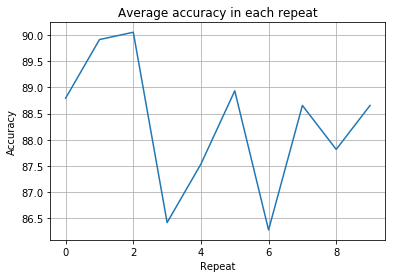

In [71]:
scores, model, history, X_test, y_test  = run_experiment(X, Y, repeats=10, architecture = 'gru')

In [72]:
print('The accuracy was %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
history, fpr, tpr, n_classes, matrix, roc_auc=metrics_def(model, history, X_test, y_test)

The accuracy was 88.305 +/- 1.228
Accuracy: 0.886555
Precision: 0.856688
Recall: 0.881967
F1 score: 0.869144
Cohens kappa: 0.769058
ROC AUC: 0.954419


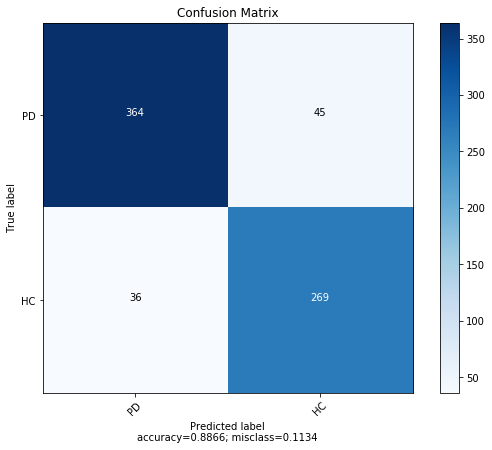

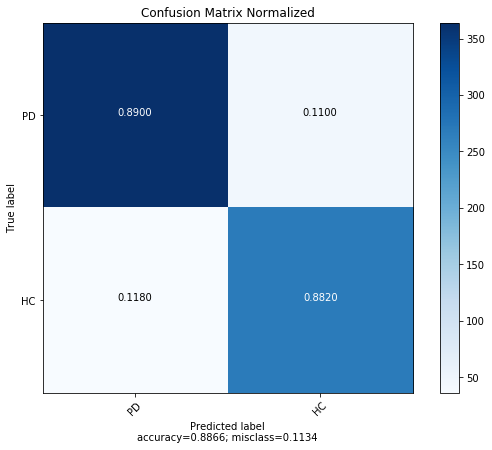

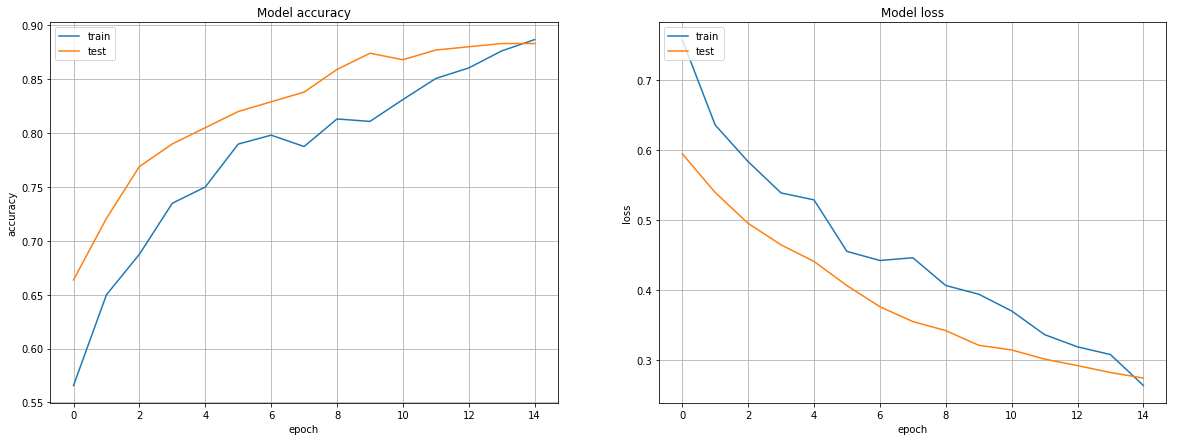

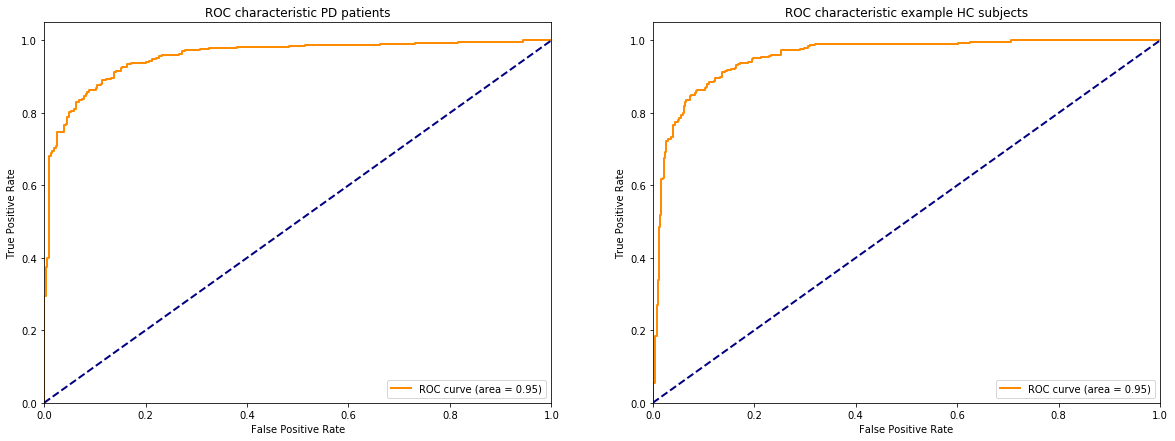

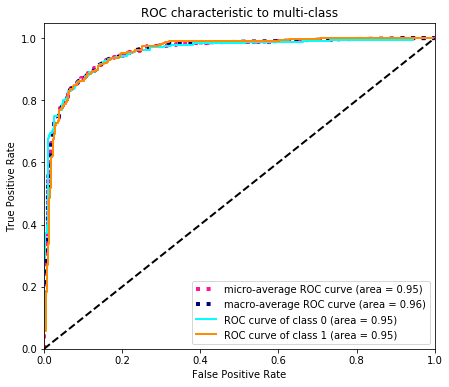

In [73]:
metric_graphics(history, fpr, tpr, n_classes, matrix, roc_auc)

### 4. Stacked LSTM: both feet

Train on 1331 samples, validate on 333 samples
Epoch 1/15
1331/1331 [==============================] - 1s 896us/sample - loss: 0.6789 - acc: 0.5815 - val_loss: 0.6668 - val_acc: 0.6126
Epoch 2/15
1331/1331 [==============================] - 0s 328us/sample - loss: 0.6442 - acc: 0.6454 - val_loss: 0.6437 - val_acc: 0.6336
Epoch 3/15
1331/1331 [==============================] - 0s 336us/sample - loss: 0.5670 - acc: 0.7198 - val_loss: 0.5095 - val_acc: 0.7658
Epoch 4/15
1331/1331 [==============================] - 0s 326us/sample - loss: 0.4303 - acc: 0.8219 - val_loss: 0.4067 - val_acc: 0.8288
Epoch 5/15
1331/1331 [==============================] - 0s 329us/sample - loss: 0.3910 - acc: 0.8400 - val_loss: 0.3479 - val_acc: 0.8799
Epoch 6/15
1331/1331 [==============================] - 0s 332us/sample - loss: 0.2990 - acc: 0.8918 - val_loss: 0.3334 - val_acc: 0.8649
Epoch 7/15
1331/1331 [==============================] - 0s 327us/sample - loss: 0.2545 - acc: 0.9091 - val_loss: 0.2555 - val

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


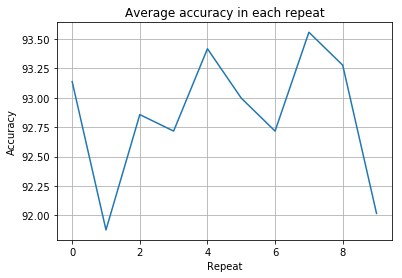

In [74]:
scores, model, history, X_test, y_test = run_experiment(X, Y, repeats=10, architecture = 'stacked_lstm')

In [75]:
print('The accuracy was %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
history, fpr, tpr, n_classes, matrix, roc_auc=metrics_def(model, history, X_test, y_test)

The accuracy was 92.857 +/- 0.528
Accuracy: 0.920168
Precision: 0.890323
Recall: 0.923077
F1 score: 0.906404
Cohens kappa: 0.836846
ROC AUC: 0.968626


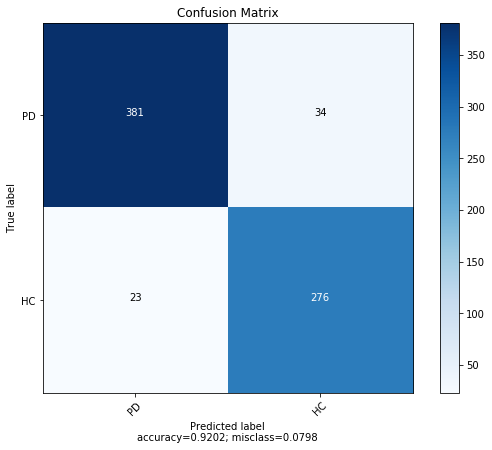

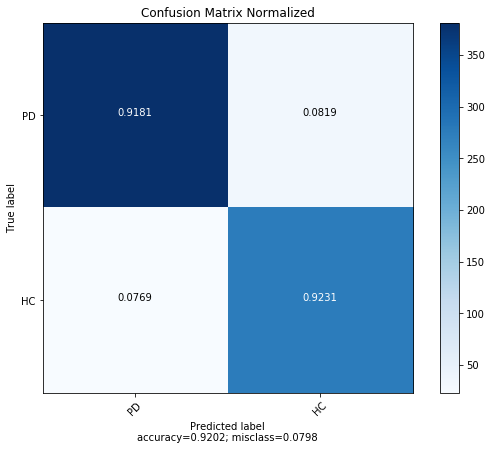

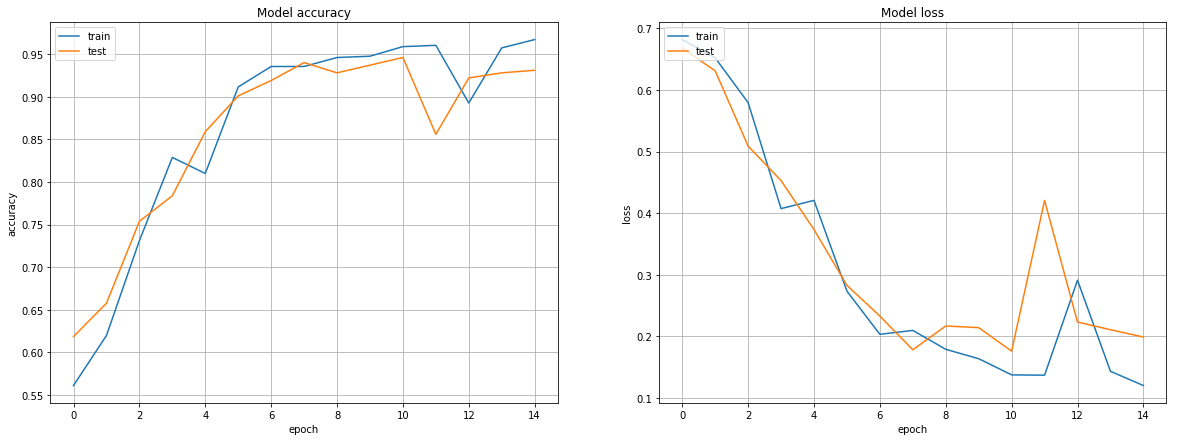

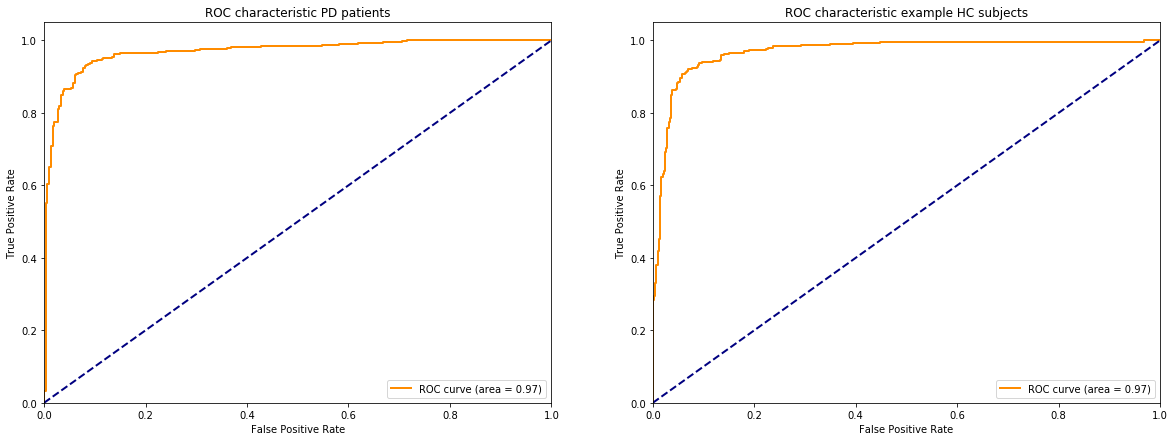

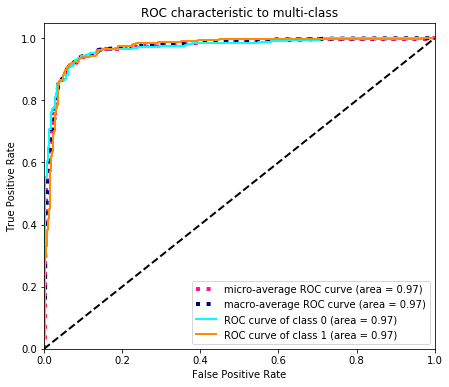

In [76]:
metric_graphics(history, fpr, tpr, n_classes, matrix, roc_auc)

### 5. LSTM: right foot

We created a new dataset with only the signals acquired at the right foot.

In [77]:
for group in groups:
    
    target = 1 if group == './gaitData/PD/' else 0
    
    for subject in fileNames:
        tempX, tempY = create_dataset(loadData(group, subject + '.mat', foot = 'right'),
                                      look_back=128, overlap = 64, label = target)        

        if group == './gaitData/EHC/' and subject ==  '001':
            X, Y = tempX, tempY
        else:             
            X, Y = np.concatenate((X, tempX), axis = 0), np.concatenate((Y, tempY), axis = 0)

# One-hot encoding 
Y = to_categorical(Y)

print(X.shape)
print(Y.shape)

(2378, 128, 6)
(2378, 2)


Train on 1331 samples, validate on 333 samples
Epoch 1/15
1331/1331 [==============================] - 1s 523us/sample - loss: 0.6831 - acc: 0.5890 - val_loss: 0.5745 - val_acc: 0.7117
Epoch 2/15
1331/1331 [==============================] - 0s 191us/sample - loss: 0.6156 - acc: 0.6642 - val_loss: 0.5363 - val_acc: 0.7688
Epoch 3/15
1331/1331 [==============================] - 0s 172us/sample - loss: 0.5665 - acc: 0.7055 - val_loss: 0.4978 - val_acc: 0.7838
Epoch 4/15
1331/1331 [==============================] - 0s 174us/sample - loss: 0.5462 - acc: 0.7378 - val_loss: 0.4485 - val_acc: 0.8258
Epoch 5/15
1331/1331 [==============================] - 0s 166us/sample - loss: 0.4953 - acc: 0.7558 - val_loss: 0.3795 - val_acc: 0.8468
Epoch 6/15
1331/1331 [==============================] - 0s 167us/sample - loss: 0.4236 - acc: 0.8152 - val_loss: 0.3357 - val_acc: 0.8739
Epoch 7/15
1331/1331 [==============================] - 0s 168us/sample - loss: 0.3894 - acc: 0.8310 - val_loss: 0.3072 - val

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


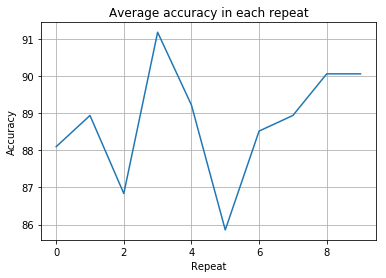

In [79]:
scores, model, history, X_test, y_test = run_experiment(X, Y, repeats=10, architecture = 'lstm')

In [80]:
print('The accuracy was %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
history, fpr, tpr, n_classes, matrix, roc_auc=metrics_def(model, history, X_test, y_test)

The accuracy was 88.768 +/- 1.487
Accuracy: 0.900560
Precision: 0.914591
Recall: 0.845395
F1 score: 0.878632
Cohens kappa: 0.794630
ROC AUC: 0.939273


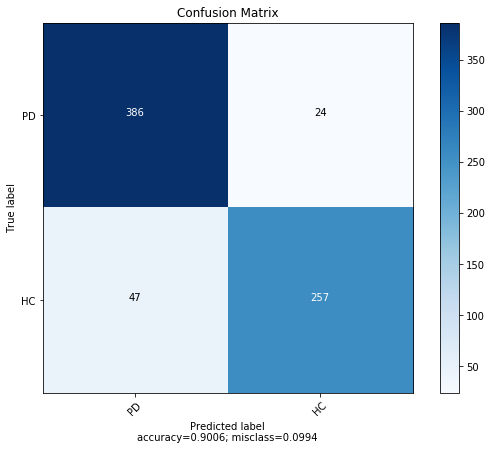

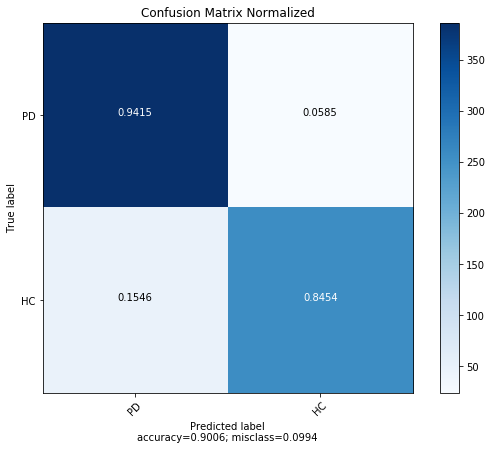

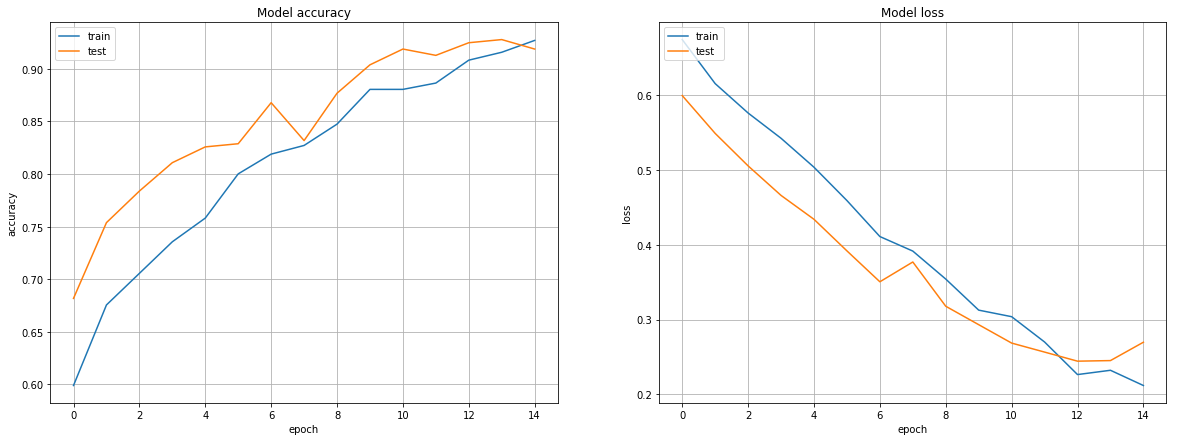

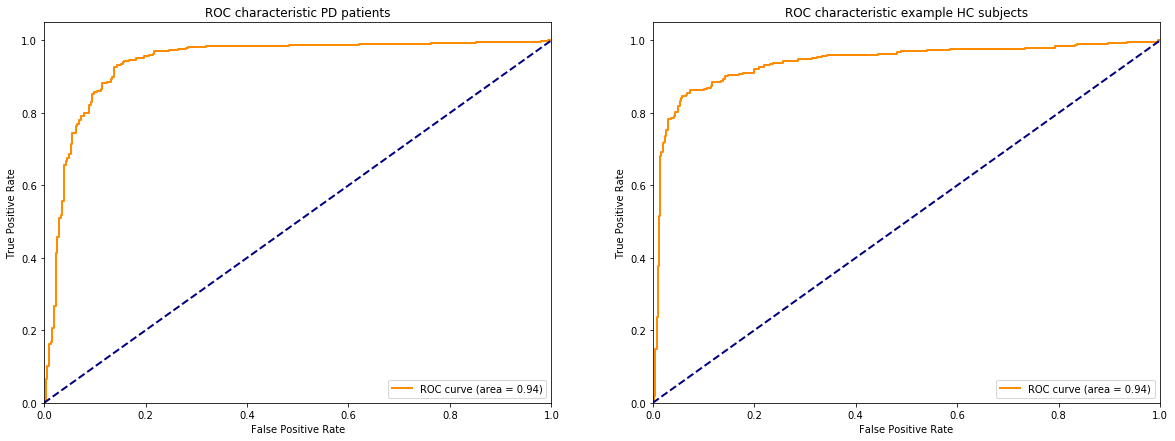

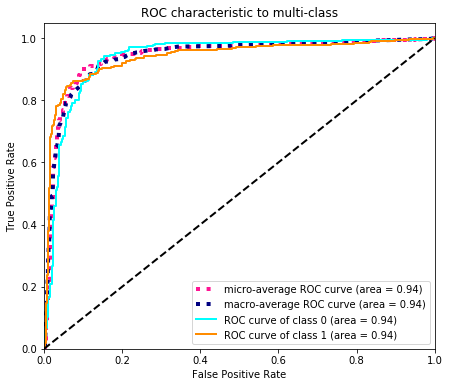

In [81]:
metric_graphics(history, fpr, tpr, n_classes, matrix, roc_auc)

### 6. RNN: right foot

Train on 1331 samples, validate on 333 samples
Epoch 1/15
1331/1331 [==============================] - 2s 1ms/sample - loss: 0.8100 - acc: 0.5507 - val_loss: 0.6910 - val_acc: 0.5736
Epoch 2/15
1331/1331 [==============================] - 2s 1ms/sample - loss: 0.7205 - acc: 0.5793 - val_loss: 0.6980 - val_acc: 0.5526
Epoch 3/15
1331/1331 [==============================] - 2s 1ms/sample - loss: 0.7006 - acc: 0.5965 - val_loss: 0.6906 - val_acc: 0.5616
Epoch 4/15
1331/1331 [==============================] - 2s 1ms/sample - loss: 0.6559 - acc: 0.6243 - val_loss: 0.6952 - val_acc: 0.5105
Epoch 5/15
1331/1331 [==============================] - 2s 1ms/sample - loss: 0.6500 - acc: 0.6251 - val_loss: 0.6883 - val_acc: 0.5676
Epoch 6/15
1331/1331 [==============================] - 2s 1ms/sample - loss: 0.6545 - acc: 0.6236 - val_loss: 0.6916 - val_acc: 0.5556
Epoch 7/15
1331/1331 [==============================] - 2s 1ms/sample - loss: 0.6530 - acc: 0.6311 - val_loss: 0.6917 - val_acc: 0.5706
E

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


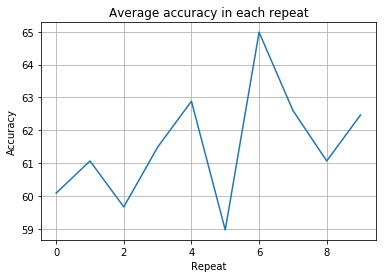

In [82]:
scores, model, history, X_test, y_test = run_experiment(X, Y, repeats=10, architecture = 'rnn')

In [83]:
print('The accuracy was %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
history, fpr, tpr, n_classes, matrix, roc_auc=metrics_def(model, history, X_test, y_test)

The accuracy was 61.527 +/- 1.685
Accuracy: 0.624650
Precision: 0.589844
Recall: 0.480892
F1 score: 0.529825
Cohens kappa: 0.222816
ROC AUC: 0.656027


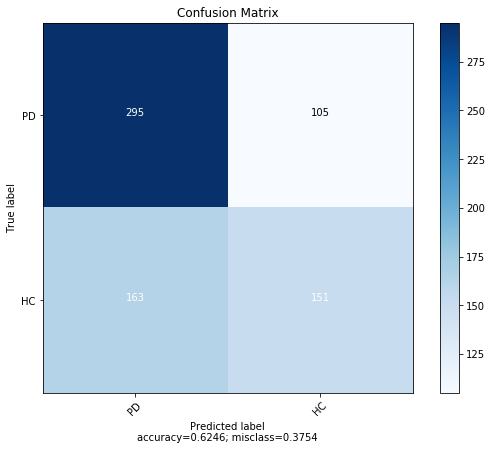

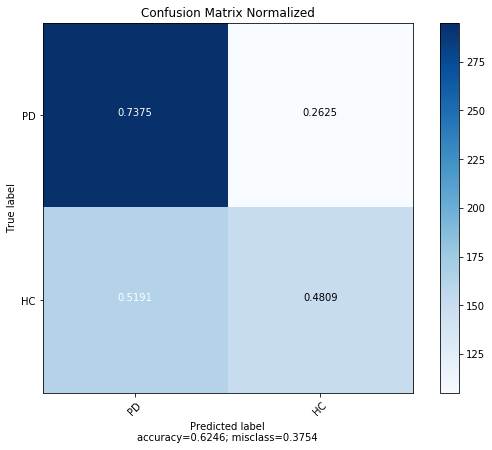

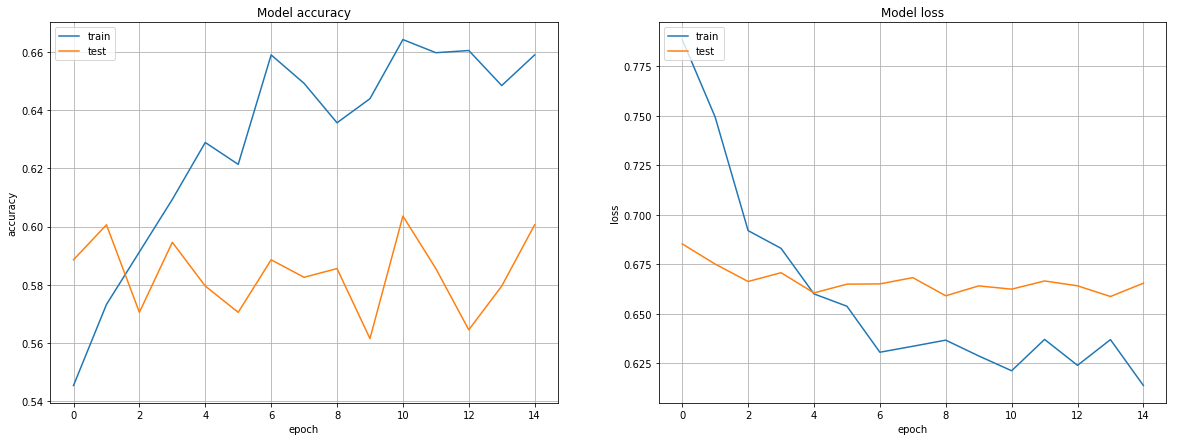

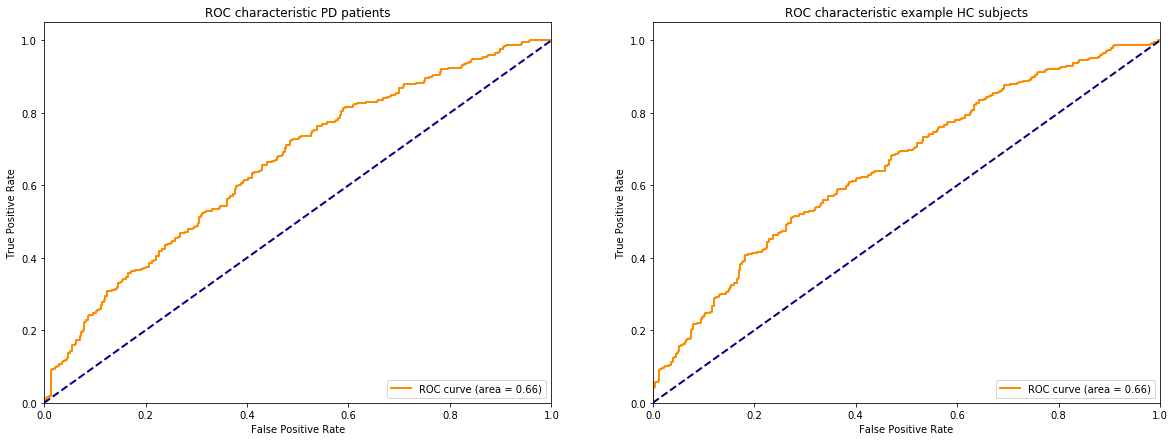

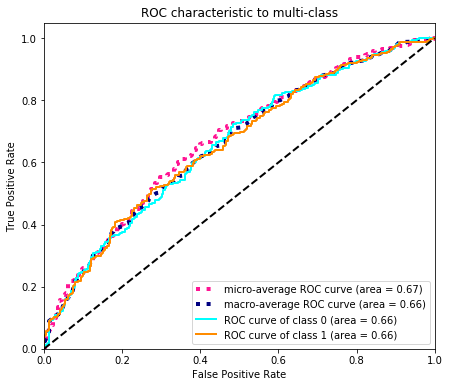

In [84]:
metric_graphics(history, fpr, tpr, n_classes, matrix, roc_auc)

### 7. GRU: right foot

Train on 1331 samples, validate on 333 samples
Epoch 1/15
1331/1331 [==============================] - 1s 509us/sample - loss: 0.7166 - acc: 0.5763 - val_loss: 0.6032 - val_acc: 0.6967
Epoch 2/15
1331/1331 [==============================] - 0s 194us/sample - loss: 0.6226 - acc: 0.6544 - val_loss: 0.5482 - val_acc: 0.7117
Epoch 3/15
1331/1331 [==============================] - 0s 172us/sample - loss: 0.5886 - acc: 0.6799 - val_loss: 0.5073 - val_acc: 0.7718
Epoch 4/15
1331/1331 [==============================] - 0s 170us/sample - loss: 0.5597 - acc: 0.7280 - val_loss: 0.5034 - val_acc: 0.7748
Epoch 5/15
1331/1331 [==============================] - 0s 164us/sample - loss: 0.5271 - acc: 0.7310 - val_loss: 0.4634 - val_acc: 0.7838
Epoch 6/15
1331/1331 [==============================] - 0s 168us/sample - loss: 0.5093 - acc: 0.7498 - val_loss: 0.4418 - val_acc: 0.8018
Epoch 7/15
1331/1331 [==============================] - 0s 159us/sample - loss: 0.4651 - acc: 0.7941 - val_loss: 0.4149 - val

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


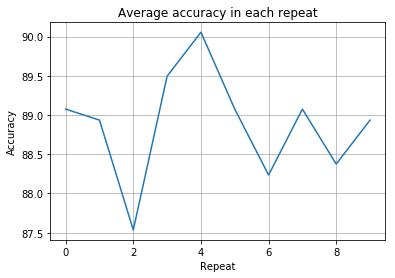

In [85]:
scores, model, history, X_test, y_test = run_experiment(X, Y, repeats=10, architecture = 'gru')

In [86]:
print('The accuracy was %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
history, fpr, tpr, n_classes, matrix, roc_auc=metrics_def(model, history, X_test, y_test)

The accuracy was 88.880 +/- 0.660
Accuracy: 0.889356
Precision: 0.841176
Recall: 0.919614
F1 score: 0.878648
Cohens kappa: 0.777345
ROC AUC: 0.943439


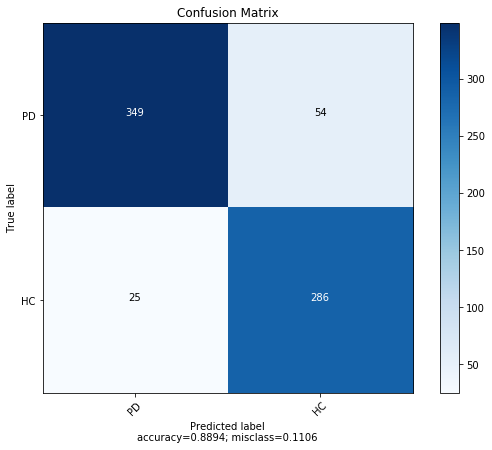

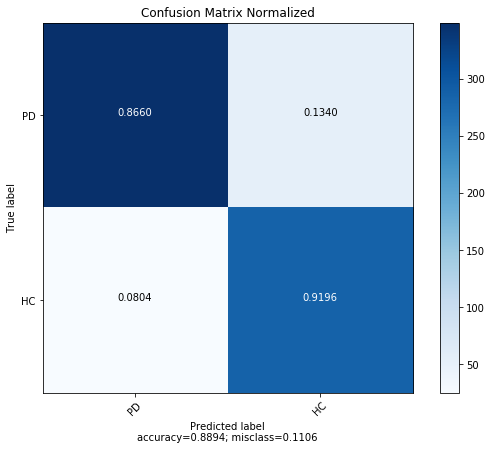

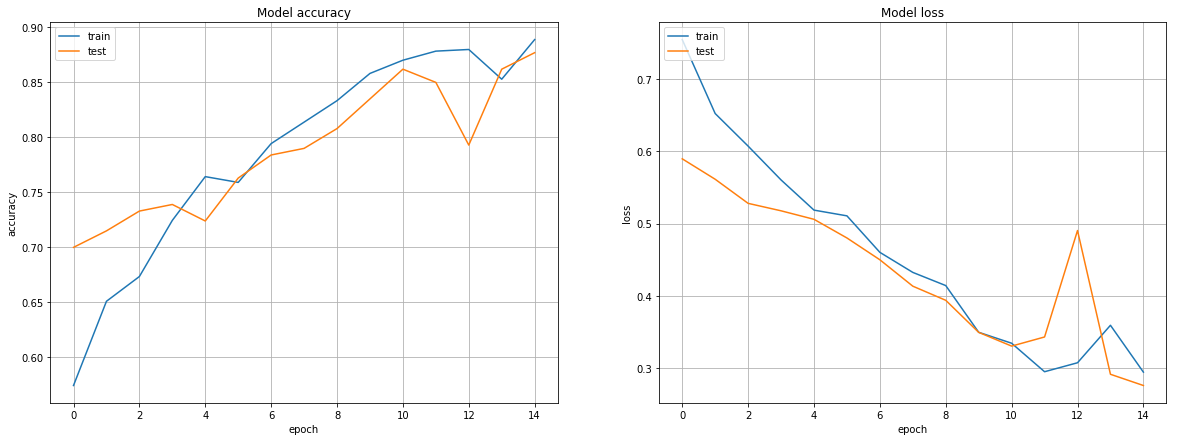

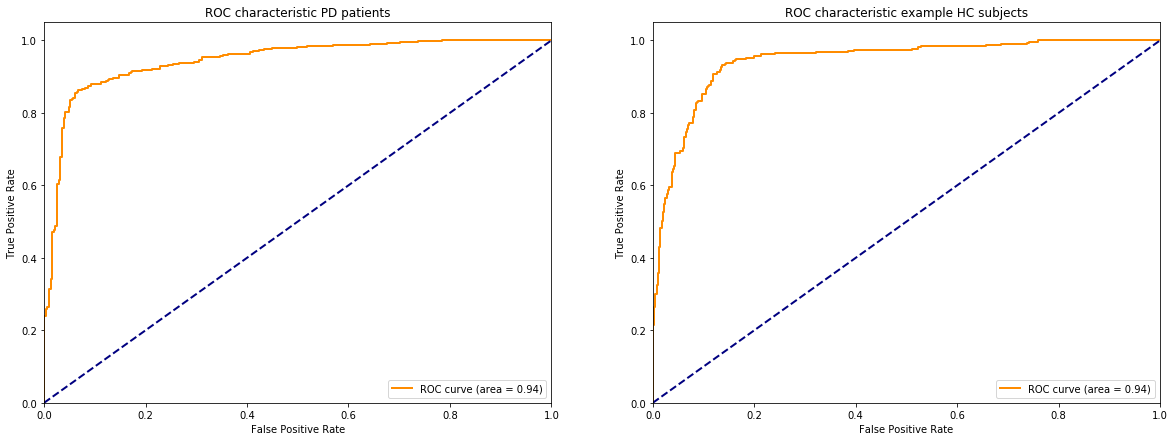

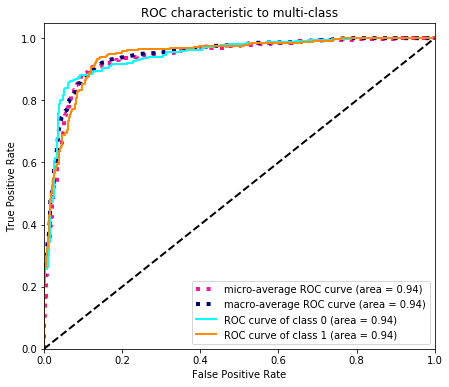

In [87]:
metric_graphics(history, fpr, tpr, n_classes, matrix, roc_auc)

### 8. Stacked LSTM: right foot

Train on 1331 samples, validate on 333 samples
Epoch 1/15
1331/1331 [==============================] - 1s 851us/sample - loss: 0.6647 - acc: 0.6033 - val_loss: 0.6317 - val_acc: 0.6486
Epoch 2/15
1331/1331 [==============================] - 0s 315us/sample - loss: 0.5740 - acc: 0.7040 - val_loss: 0.5313 - val_acc: 0.7718
Epoch 3/15
1331/1331 [==============================] - 0s 318us/sample - loss: 0.4577 - acc: 0.8182 - val_loss: 0.4349 - val_acc: 0.8288
Epoch 4/15
1331/1331 [==============================] - 0s 314us/sample - loss: 0.4194 - acc: 0.8272 - val_loss: 0.4412 - val_acc: 0.8258
Epoch 5/15
1331/1331 [==============================] - 0s 316us/sample - loss: 0.3815 - acc: 0.8550 - val_loss: 0.4232 - val_acc: 0.8318
Epoch 6/15
1331/1331 [==============================] - 0s 310us/sample - loss: 0.3795 - acc: 0.8535 - val_loss: 0.4230 - val_acc: 0.8408
Epoch 7/15
1331/1331 [==============================] - 0s 316us/sample - loss: 0.4276 - acc: 0.8302 - val_loss: 0.5247 - val

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


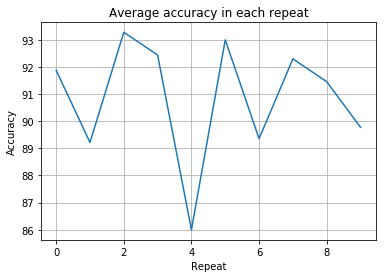

In [88]:
scores, model, history, X_test, y_test = run_experiment(X, Y, repeats=10, architecture = 'stacked_lstm')

In [89]:
print('The accuracy was %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
history, fpr, tpr, n_classes, matrix, roc_auc=metrics_def(model, history, X_test, y_test)

The accuracy was 90.868 +/- 2.149
Accuracy: 0.897759
Precision: 0.892473
Recall: 0.852740
F1 score: 0.872154
Cohens kappa: 0.787047
ROC AUC: 0.959521


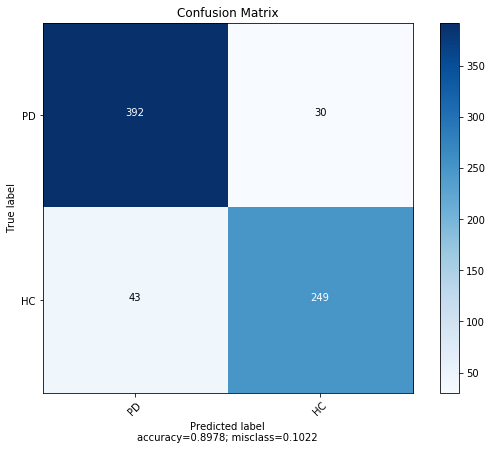

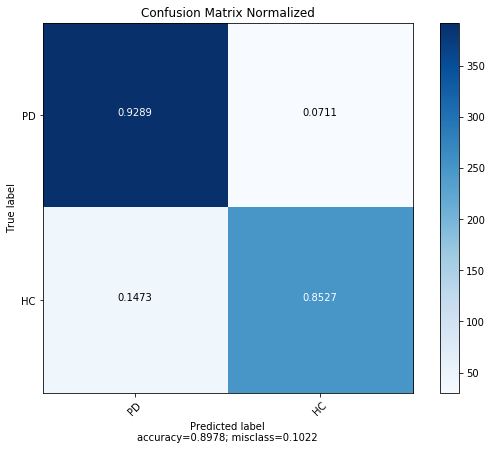

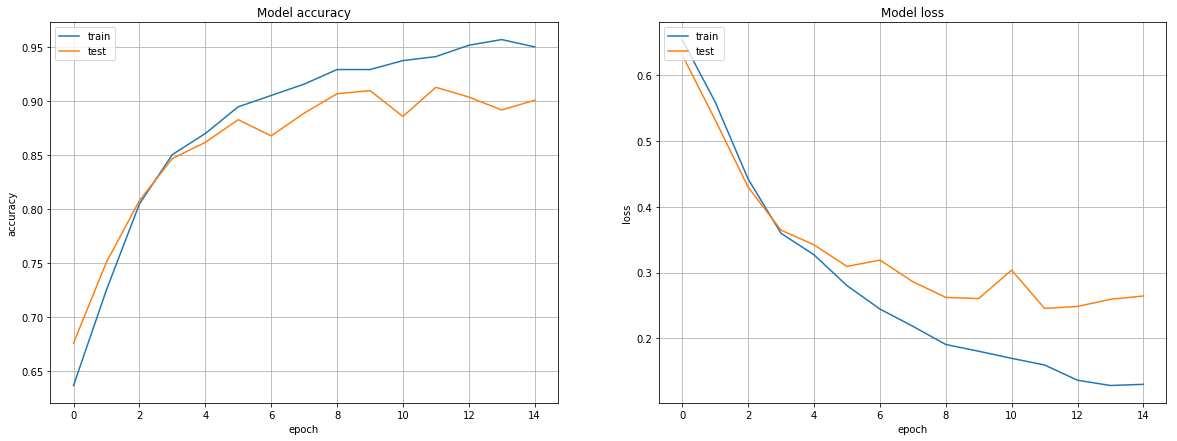

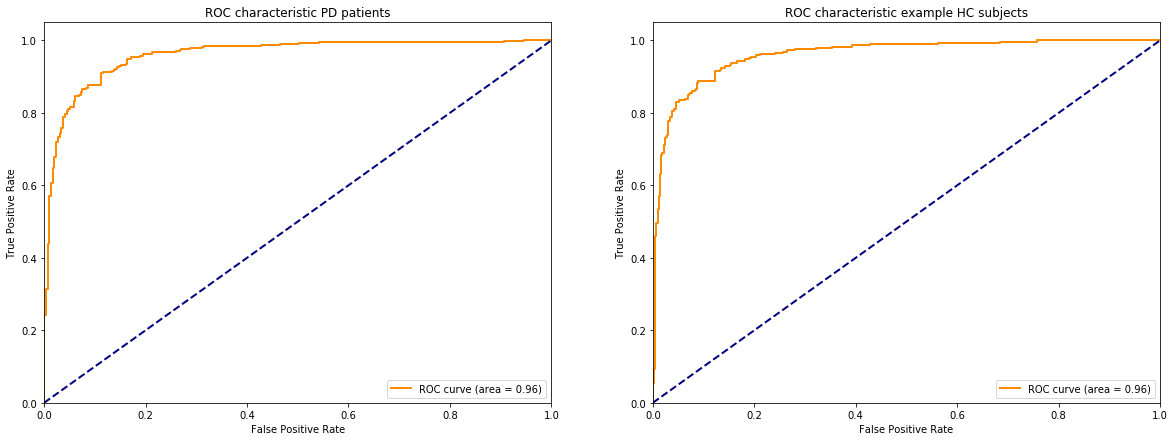

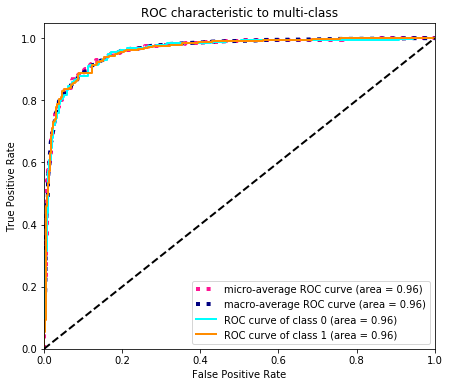

In [90]:
metric_graphics(history, fpr, tpr, n_classes, matrix, roc_auc)

### 9. LSTM: left foot

Next, we created a new dataset with only the signals acquired at the left foot.

In [91]:
for group in groups:
    
    target = 1 if group == './gaitData/PD/' else 0
    
    for subject in fileNames:
        tempX, tempY = create_dataset(loadData(group, subject + '.mat', foot = 'right'),
                                      look_back=128, overlap = 64, label = target)        

        if group == './gaitData/EHC/' and subject ==  '001':
            X, Y = tempX, tempY
        else:             
            X, Y = np.concatenate((X, tempX), axis = 0), np.concatenate((Y, tempY), axis = 0)

# One-hot encoding 
Y = to_categorical(Y)

print(X.shape)
print(Y.shape)

(2378, 128, 6)
(2378, 2)


Train on 1331 samples, validate on 333 samples
Epoch 1/15
1331/1331 [==============================] - 1s 522us/sample - loss: 0.6598 - acc: 0.6026 - val_loss: 0.5920 - val_acc: 0.6967
Epoch 2/15
1331/1331 [==============================] - 0s 203us/sample - loss: 0.6028 - acc: 0.6694 - val_loss: 0.5448 - val_acc: 0.7477
Epoch 3/15
1331/1331 [==============================] - 0s 171us/sample - loss: 0.5518 - acc: 0.7258 - val_loss: 0.5081 - val_acc: 0.7868
Epoch 4/15
1331/1331 [==============================] - 0s 173us/sample - loss: 0.5187 - acc: 0.7566 - val_loss: 0.4841 - val_acc: 0.8078
Epoch 5/15
1331/1331 [==============================] - 0s 178us/sample - loss: 0.4791 - acc: 0.7754 - val_loss: 0.4606 - val_acc: 0.8138
Epoch 6/15
1331/1331 [==============================] - 0s 175us/sample - loss: 0.4355 - acc: 0.8024 - val_loss: 0.4236 - val_acc: 0.8378
Epoch 7/15
1331/1331 [==============================] - 0s 168us/sample - loss: 0.3945 - acc: 0.8212 - val_loss: 0.3933 - val

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


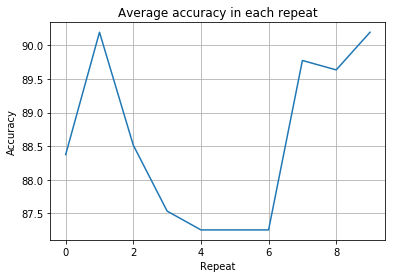

In [92]:
scores, model, history, X_test, y_test  = run_experiment(X, Y, repeats=10, architecture = 'lstm')

In [93]:
print('The accuracy was %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
history, fpr, tpr, n_classes, matrix, roc_auc=metrics_def(model, history, X_test, y_test)

The accuracy was 88.599 +/- 1.190
Accuracy: 0.901961
Precision: 0.880878
Recall: 0.897764
F1 score: 0.889241
Cohens kappa: 0.801315
ROC AUC: 0.956626


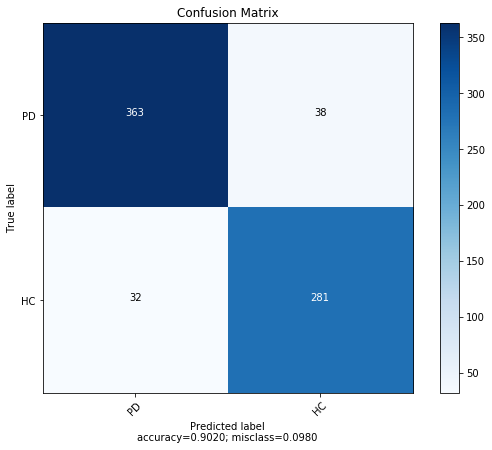

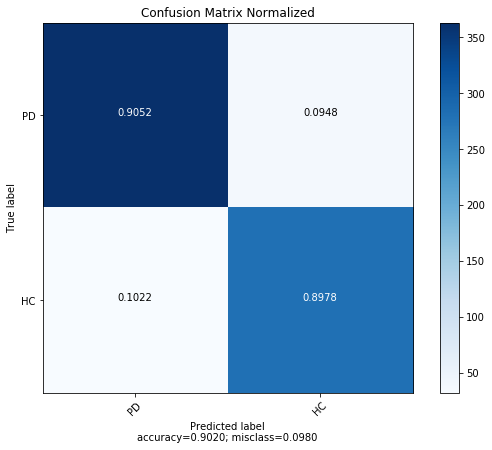

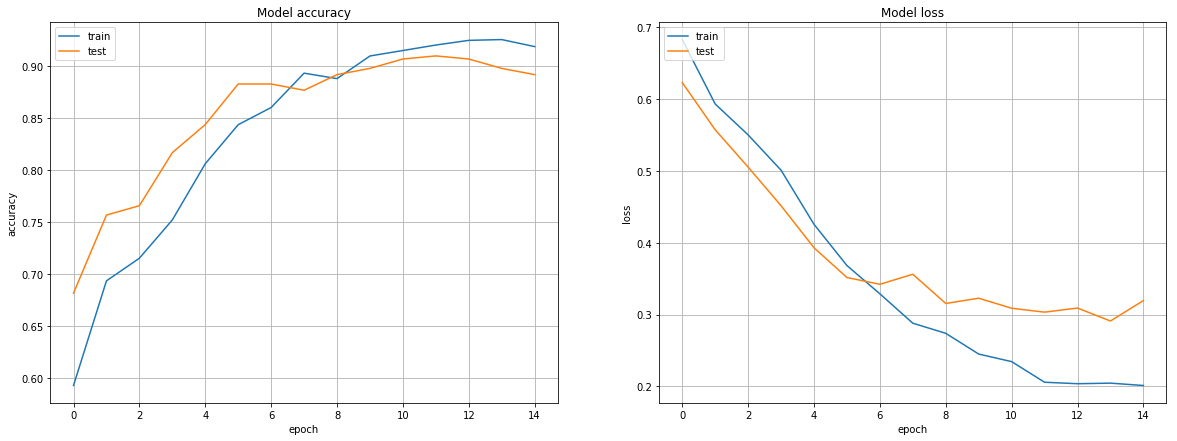

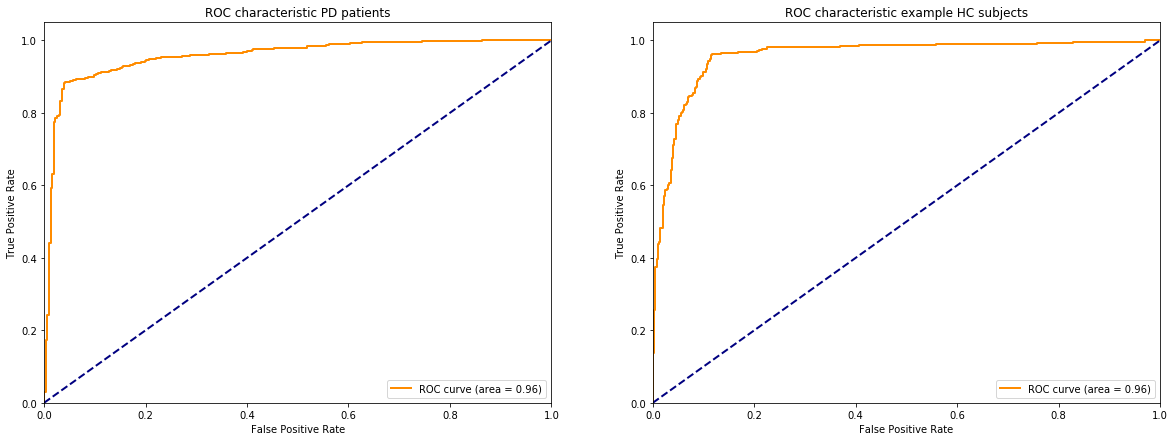

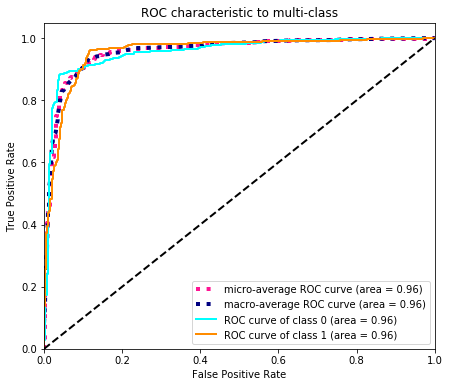

In [94]:
metric_graphics(history, fpr, tpr, n_classes, matrix, roc_auc)

### 10. RNN: left foot

Train on 1331 samples, validate on 333 samples
Epoch 1/15
1331/1331 [==============================] - 2s 1ms/sample - loss: 0.8747 - acc: 0.5432 - val_loss: 0.8095 - val_acc: 0.4264
Epoch 2/15
1331/1331 [==============================] - 2s 1ms/sample - loss: 0.7466 - acc: 0.5733 - val_loss: 0.6408 - val_acc: 0.6426
Epoch 3/15
1331/1331 [==============================] - 2s 1ms/sample - loss: 0.7090 - acc: 0.5800 - val_loss: 0.6630 - val_acc: 0.5886
Epoch 4/15
1331/1331 [==============================] - 2s 1ms/sample - loss: 0.7011 - acc: 0.5845 - val_loss: 0.6414 - val_acc: 0.6547
Epoch 5/15
1331/1331 [==============================] - 2s 1ms/sample - loss: 0.6636 - acc: 0.6296 - val_loss: 0.6337 - val_acc: 0.6486
Epoch 6/15
1331/1331 [==============================] - 2s 1ms/sample - loss: 0.6649 - acc: 0.6123 - val_loss: 0.6135 - val_acc: 0.6847
Epoch 7/15
1331/1331 [==============================] - 2s 1ms/sample - loss: 0.6626 - acc: 0.6273 - val_loss: 0.6302 - val_acc: 0.6426
E

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


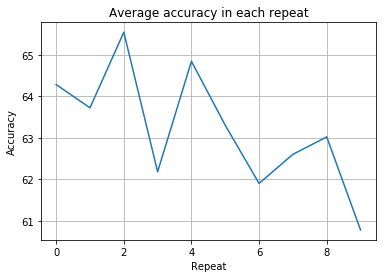

In [120]:
scores, model, history, X_test, y_test = run_experiment(X, Y, repeats=10, architecture = 'rnn')

In [121]:
print('The accuracy was %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
history, fpr, tpr, n_classes, matrix, roc_auc=metrics_def(model, history, X_test, y_test)

The accuracy was 63.221 +/- 1.364
Accuracy: 0.607843
Precision: 0.593750
Recall: 0.413043
F1 score: 0.487179
Cohens kappa: 0.185954
ROC AUC: 0.678627


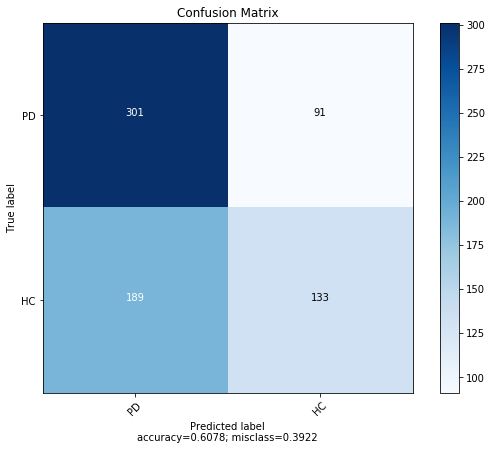

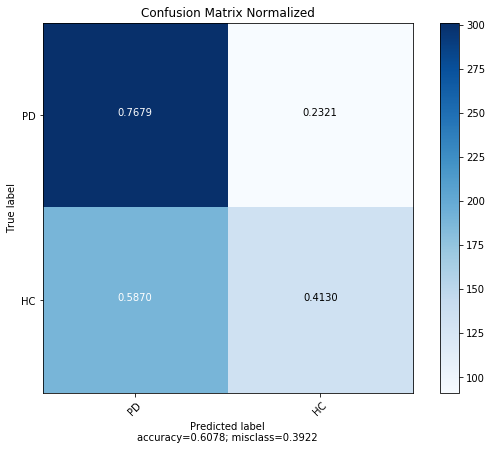

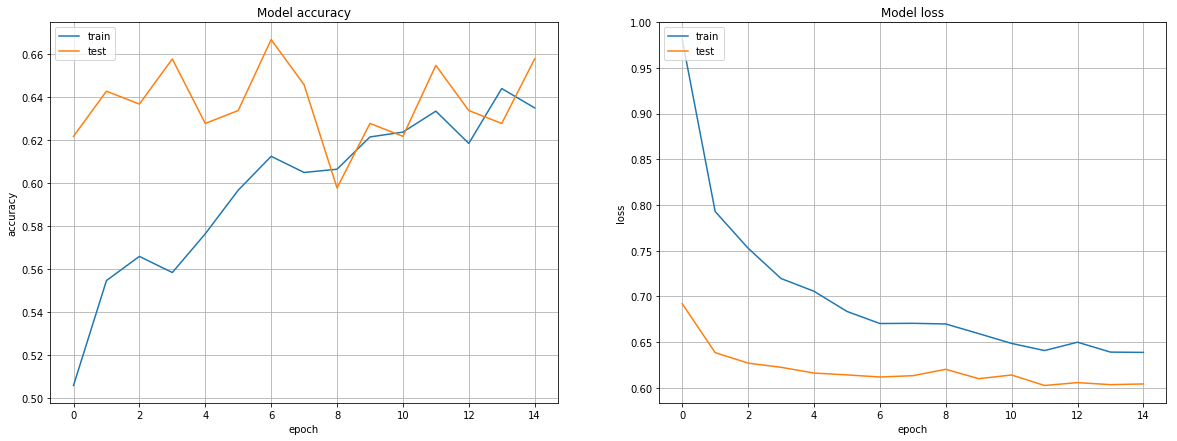

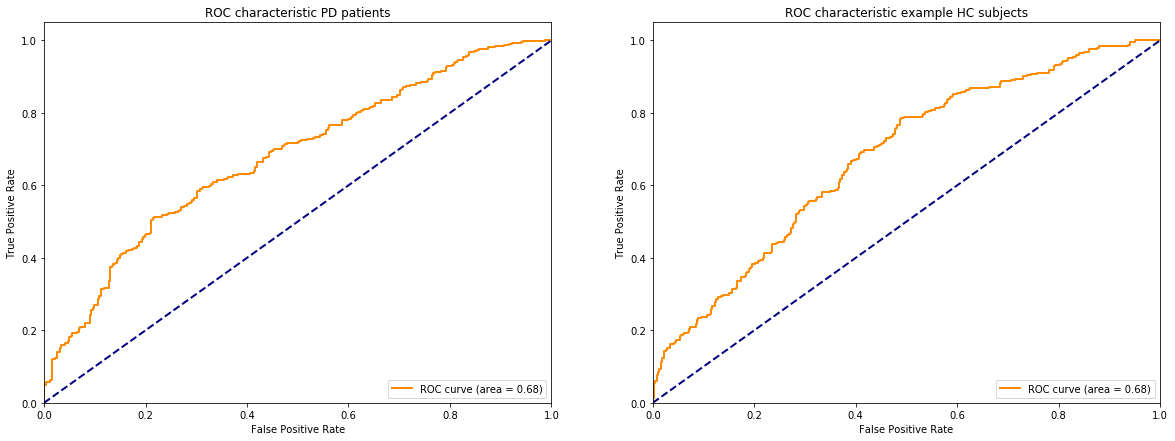

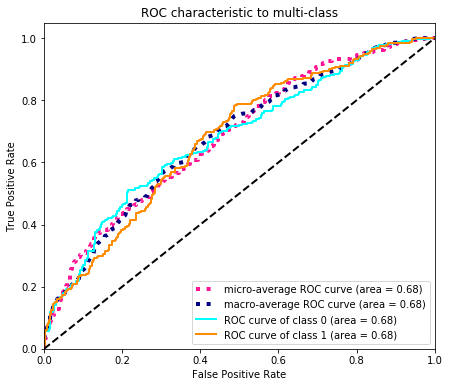

In [122]:
metric_graphics(history, fpr, tpr, n_classes, matrix, roc_auc)

### 11. GRU: left foot

Train on 1331 samples, validate on 333 samples
Epoch 1/15
1331/1331 [==============================] - 1s 533us/sample - loss: 0.7896 - acc: 0.5507 - val_loss: 0.5849 - val_acc: 0.6817
Epoch 2/15
1331/1331 [==============================] - 0s 206us/sample - loss: 0.6009 - acc: 0.6875 - val_loss: 0.5161 - val_acc: 0.7447
Epoch 3/15
1331/1331 [==============================] - 0s 168us/sample - loss: 0.5489 - acc: 0.7243 - val_loss: 0.4810 - val_acc: 0.7928
Epoch 4/15
1331/1331 [==============================] - 0s 166us/sample - loss: 0.4988 - acc: 0.7596 - val_loss: 0.4480 - val_acc: 0.7598
Epoch 5/15
1331/1331 [==============================] - 0s 161us/sample - loss: 0.4681 - acc: 0.7746 - val_loss: 0.4195 - val_acc: 0.7988
Epoch 6/15
1331/1331 [==============================] - 0s 161us/sample - loss: 0.4193 - acc: 0.8024 - val_loss: 0.4024 - val_acc: 0.7898
Epoch 7/15
1331/1331 [==============================] - 0s 169us/sample - loss: 0.4017 - acc: 0.8084 - val_loss: 0.3788 - val

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


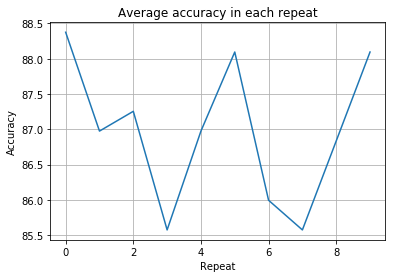

In [123]:
scores, model, history, X_test, y_test = run_experiment(X, Y, repeats=10, architecture = 'gru')

In [125]:
print('The accuracy was %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
history, fpr, tpr, n_classes, matrix,roc_auc=metrics_def(model, history, X_test, y_test)

The accuracy was 86.975 +/- 0.972
Accuracy: 0.880952
Precision: 0.868512
Recall: 0.842282
F1 score: 0.855196
Cohens kappa: 0.754166
ROC AUC: 0.941291


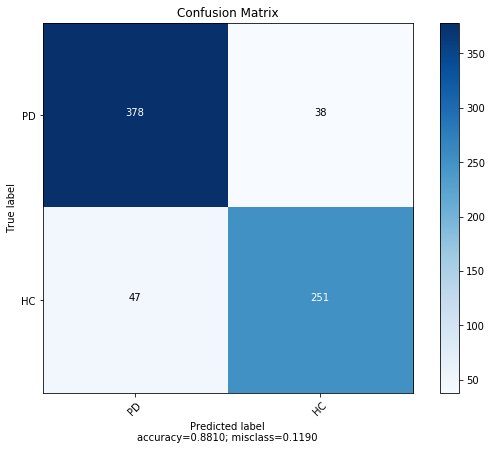

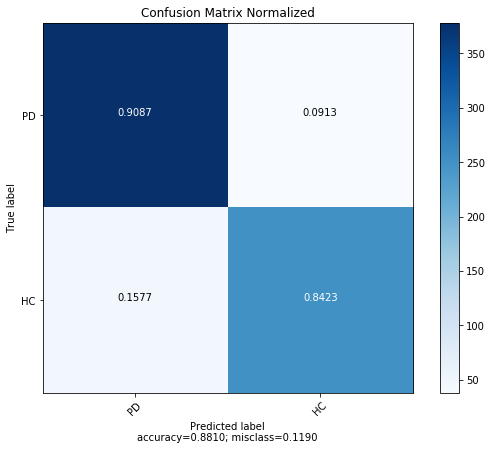

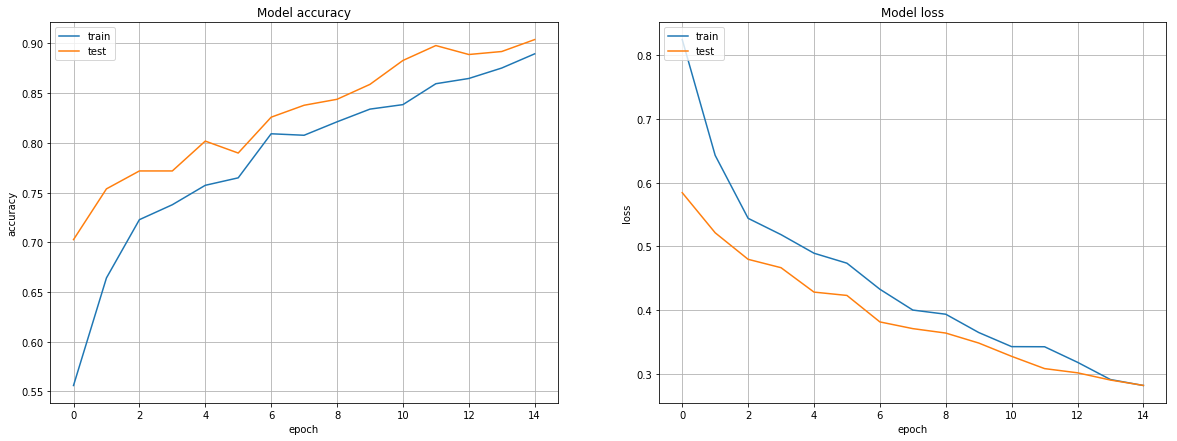

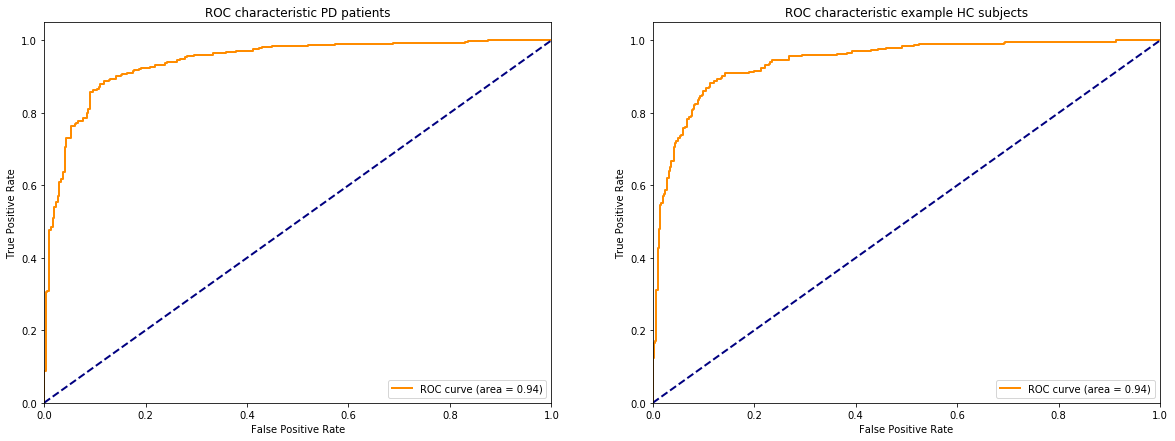

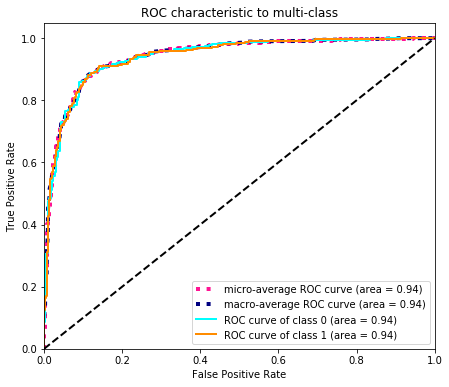

In [126]:
metric_graphics(history, fpr, tpr, n_classes, matrix, roc_auc)

### 12. Stacked LSTM: left foot

Train on 1331 samples, validate on 333 samples
Epoch 1/15
1331/1331 [==============================] - 1s 875us/sample - loss: 0.6745 - acc: 0.5860 - val_loss: 0.6735 - val_acc: 0.6006
Epoch 2/15
1331/1331 [==============================] - 0s 327us/sample - loss: 0.6265 - acc: 0.6521 - val_loss: 0.6097 - val_acc: 0.6486
Epoch 3/15
1331/1331 [==============================] - 0s 325us/sample - loss: 0.5161 - acc: 0.7521 - val_loss: 0.4254 - val_acc: 0.8228
Epoch 4/15
1331/1331 [==============================] - 0s 328us/sample - loss: 0.3513 - acc: 0.8580 - val_loss: 0.3791 - val_acc: 0.8589
Epoch 5/15
1331/1331 [==============================] - 0s 331us/sample - loss: 0.2937 - acc: 0.8881 - val_loss: 0.2839 - val_acc: 0.8949
Epoch 6/15
1331/1331 [==============================] - 0s 320us/sample - loss: 0.3696 - acc: 0.8693 - val_loss: 0.3408 - val_acc: 0.8468
Epoch 7/15
1331/1331 [==============================] - 0s 326us/sample - loss: 0.3143 - acc: 0.8768 - val_loss: 0.2956 - val

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


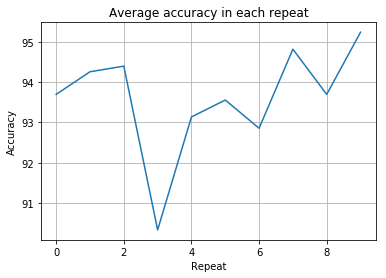

In [127]:
scores, model, history, X_test, y_test = run_experiment(X, Y, repeats=10, architecture = 'stacked_lstm')

In [128]:
print('The accuracy was %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
history, fpr, tpr, n_classes, matrix, roc_auc=metrics_def(model, history, X_test, y_test)

The accuracy was 93.599 +/- 1.291
Accuracy: 0.952381
Precision: 0.949833
Recall: 0.937294
F1 score: 0.943522
Cohens kappa: 0.902363
ROC AUC: 0.985779


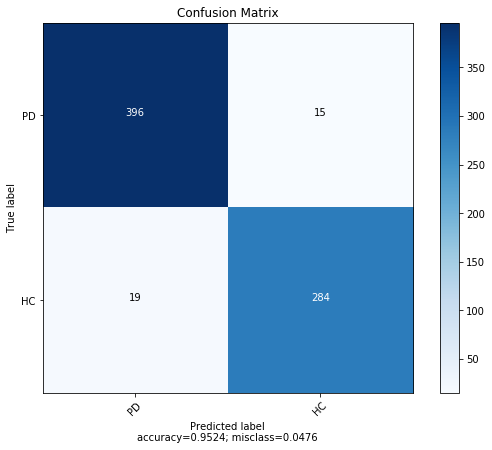

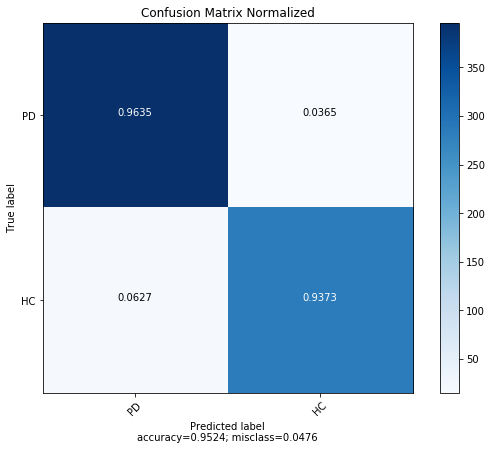

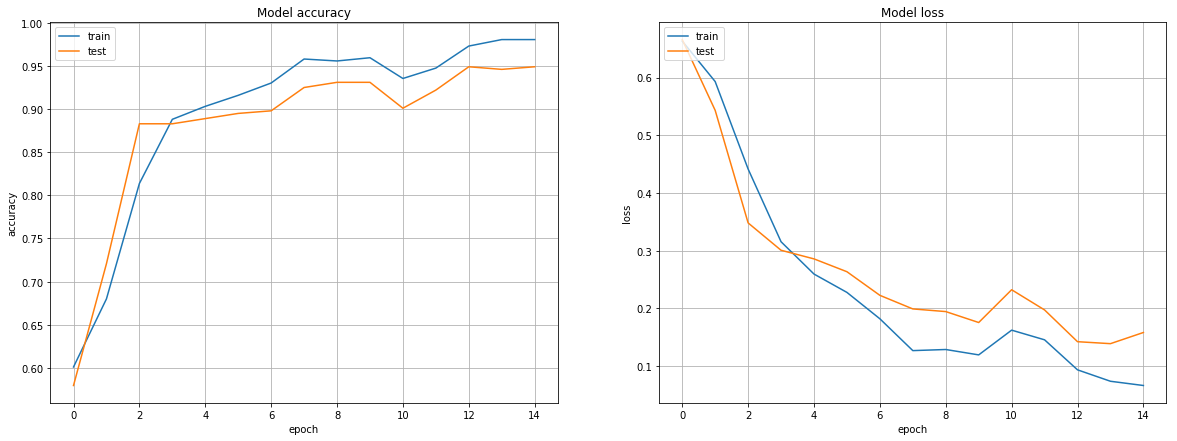

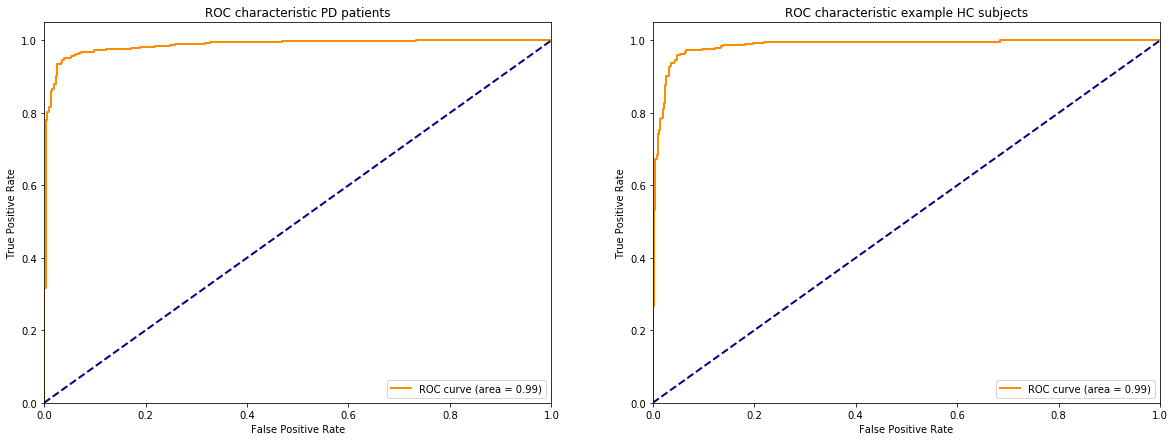

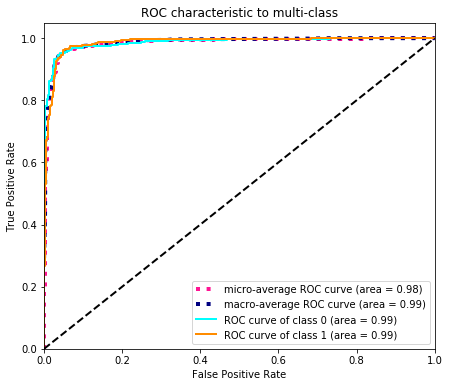

In [129]:
metric_graphics(history, fpr, tpr, n_classes, matrix, roc_auc)